# Setup

In [1]:
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
# Boilerplate startup code

import numpy as np
import pandas as pd
from tqdm import tqdm
from hax.ipython import code_hider

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

from pax import units

# Special analysis tools: may go into hax soon
#from load_led import load_led_data
from hax.pmt_plot import plot_on_pmt_arrays, pmt_data

#code_hider()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
import pymongo
import os
import sys

def get_file_path(run_number):
    uri = 'mongodb://eb:%s@xenon1t-daq.lngs.infn.it:27017,copslx50.fysik.su.se:27017,zenigata.uchicago.edu:27017/run'
    uri = uri % os.environ.get('MONGO_PASSWORD')
    c = pymongo.MongoClient(uri,
                            replicaSet='runs',
                            readPreference='secondaryPreferred')
    db = c['run']
    collection = db['runs_new']                                                                                                                                                         
    query = {"detector":"tpc", "number":run_number}

    cursor = collection.find(query, {"number" : True,
                                 "data.host": True,
                                 "data.status" : True,
                                 "data.type":True,
                                 "data.location":True,
                                  "_id":False})
    cursor = list(cursor)
    entry_list = cursor[0]['data']
    for entry in entry_list:
        if entry['host'] == 'midway-login1' and entry['type'] == 'raw':
            if entry['status'] != 'transferred':
                print('Raw file not present')
                return
            path = entry['location']
    print('raw data at %s' % path)
    return path

In [36]:
from pax import core, units, dsputils

mypax = core.Processor(config_names='XENON1T', config_dict={
    'pax': {
            'plugin_group_names': ['input', 'preprocessing'],
            'preprocessing':      ['CheckPulses.SortPulses',
                                   'CheckPulses.ConcatenateAdjacentPulses',],
            'input':              'Zip.ReadZipped',
            'encoder_plugin':     None,
            #'decoder_plugin':     'BSON.DecodeZBSON',
            'input_name':           get_file_path(4512)
            #'input_name':         '/project/kicp/ershockley/160916_1153'  #Run 2916
            #'input_name':           #Run 2244 1550V
        }
    })

output_file = 'run2915_thresholds.csv'

def get_events():
    for event in mypax.get_events():
        event = mypax.process_event(event)
        yield event
event_generator = get_events()

event = next(event_generator)

raw data at /project/lgrandi/xenon1t/raw/161111_1741


INFO:processor:This is PAX version 6.1.0, running with configuration for XENON1T.
INFO:ReadZipped:InputFromFolder: Selecting file /project/lgrandi/xenon1t/raw/161111_1741/XENON1T-4512-000000000-000000999-000001000.zip (number 1/195 in folder) for reading


In [37]:
event1_start = event.start_time
event1_stop = event.stop_time
event = next(event_generator)
event2_start = event.start_time
event2_stop = event.stop_time

print(event1_start, event1_stop, (event1_stop - event1_start)/1.0e3)
print(event2_start, event2_stop, (event2_stop - event2_start)/1.0e3)
print(event2_start, event1_start, (event2_start - event1_start)/1.0e6)


1478886068000278590 1478886068000388590 110.0
1478886068002736170 1478886068002846170 110.0
1478886068002736170 1478886068000278590 2.45758


In [38]:
nevents = mypax.input_plugin.number_of_events
print("Number of events: %d" %nevents)
npulses = len(event.pulses)
print("Number of pulses per event: %d" %npulses)
samples_per_pulse = len(event.pulses[0].raw_data)
print("Number of samples per pulse: %d" %samples_per_pulse)
board_1_channels = [25, 26, 27, 28, 29, 30,
                    57, 58, 59, 60, 61,
                    82, 83, 84, 85, 86,
                    102, 103, 104, 105,
                    116, 117, 118,
                    125]
board_2_channels = [13, 14, 15, 16, 17, 18,
                    47, 48, 49, 50, 51, 52,
                    75, 76, 77, 78, 79,
                    97, 98, 99, 100,
                    113, 114,
                    123]
board_7_channels = [157, 158,
                    167, 168, 169,
                    177, 178, 179, 180, 181,
                    188, 189, 190, 191, 192,
                    201, 202, 203, 204,
                    213, 214, 215,
                    224, 225]

Number of events: 194930
Number of pulses per event: 254
Number of samples per pulse: 600


In [39]:
show_channels = board_1_channels

# Noise Amplitude and SPE spectrum

In [73]:
amplitude_bounds = (-100, 2000)
n_channels = 254
n_loop_events = 50000 # nevents


import multihist
import gc

noise_hist = multihist.Histdd(axis_names=['channel', 'amplitude'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

spe_hist = multihist.Histdd(axis_names=['channel', 'amplitude'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

noise_dt_1 = multihist.Hist1d(bins=np.arange(0, 400))
noise_dt_2 = multihist.Hist1d(bins=np.arange(0, 400))

In [74]:
def get_events():
    for event in mypax.get_events():
        event = mypax.process_event(event)
        yield event
event_generator = get_events()

In [75]:
good_events_seen = 0

average_waveform = np.zeros(600)


for event_i in tqdm(range(n_loop_events)):
    event = next(event_generator)
    if not len(event.pulses) == n_channels:
        # Ignore weird events where not all channels are present
        # These are probably due to a bug in the event builder
        continue
    good_events_seen += 1
    channel_list = np.ones(n_channels)
    amplitude_list = np.ones(n_channels)
    counter = 0
    #average_waveform_of_pulse = np.zeros(200)
    for p in event.pulses:
        #if p.channel not in show_channels:
            #continue;
        ch = p.channel
        w = p.raw_data
        assert len(w) == samples_per_pulse
        w = np.median(w) - w     # Baseline the waveform by subtracting the median, flip signal
        w = np.clip(w, *amplitude_bounds)
        channel_list[counter] = p.channel
        amplitude_list[counter] = max(w)
        
        #if max(w) <= 40:
            #average_waveform_of_pulse += w
        #noise_hist.add(np.ones(len(w))*p.channel, w)
        
        
        counter+=1
        

    spe_hist.add(channel_list, amplitude_list)
 

print("%d proper events seen in %d events" % (good_events_seen, n_loop_events))

 98%|█████████▊| 48999/50000 [40:41<00:47, 21.16it/s]INFO:ReadZipped:InputFromFolder: Selecting file /project/lgrandi/xenon1t/raw/161111_1741/XENON1T-4512-000049000-000049999-000001000.zip (number 50/195 in folder) for reading


50000 proper events seen in 50000 events


We have 0.3000 sec per channel, so rates below 3.3 Hz are definitely unrealiable!


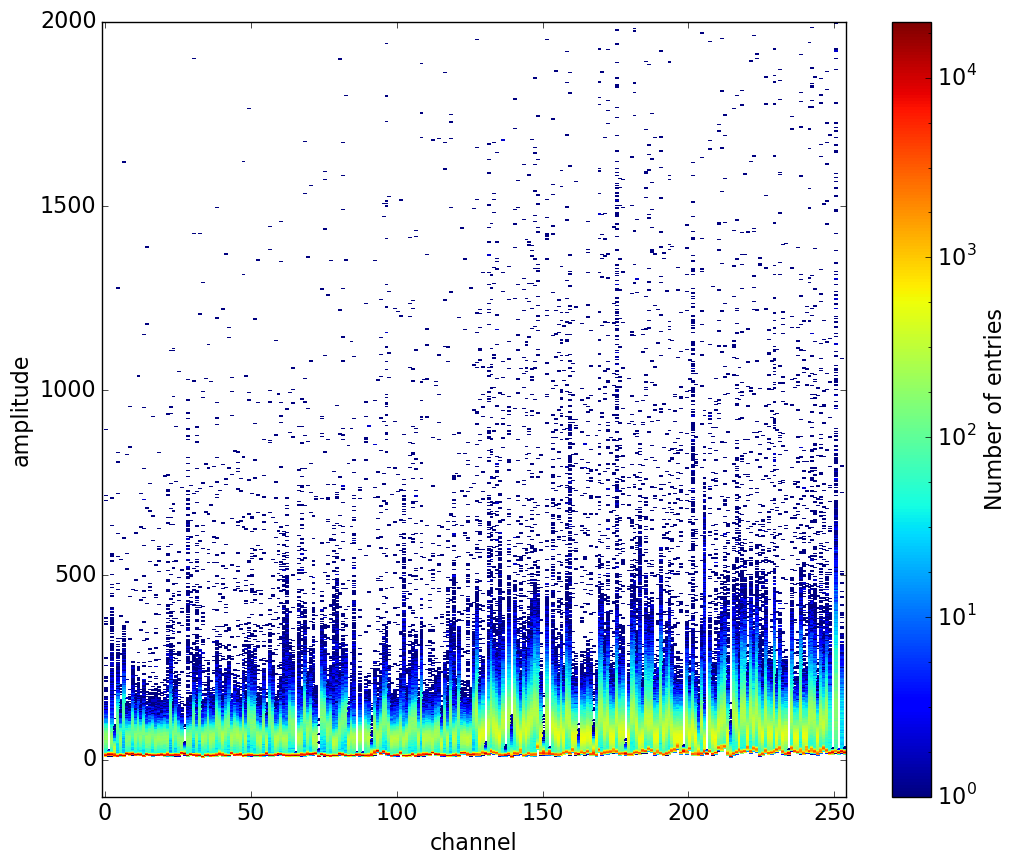

In [76]:
time_per_channel = good_events_seen * samples_per_pulse * 10 * units.ns

#amplitude_survival = noise_hist.cumulative_density('amplitude')
#amplitude_survival.histogram = 1 - amplitude_survival.histogram
#amplitude_survival.histogram *= noise_hist.project('channel').histogram[:, np.newaxis] / time_per_channel / units.Hz


max_rate_hz = 1/time_per_channel / units.Hz
print("We have %0.4f sec per channel, so rates below %0.1f Hz are definitely unrealiable!" %
      (time_per_channel / units.s, max_rate_hz))

#noise_hist.plot(log_scale = True)
#plt.show()

spe_hist.plot(log_scale=True)
plt.show()


In [77]:
from matplotlib import cm
from scipy.optimize import curve_fit

def style_yaxis(ax, label='', color='black'):
    ax.set_ylabel(label, color=color)
    for tl in ax.get_yticklabels():
        tl.set_color(color)
        
def gauss(x, const, mu, sigma):
    G = const * np.exp(-(x-mu)**2 / (2*sigma**2))
    return G

def double_gauss(x, const1, const2, mu1, mu2, sigma1, sigma2):
    G = gauss(x, const1, mu1, sigma1) + gauss(x, const2, mu2, sigma2)
    return G

def fit_with_gauss(xdata, ydata, xmin, xmax, first_guess = None):
    fit_xdata = [x for x in xdata if xmin<x<xmax]
    fit_ydata = [y for i,y in enumerate(ydata) if xmin<xdata[i]<xmax]
    assert len(fit_xdata) == len(fit_ydata)
    par_bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])
    pars, cov = curve_fit(gauss, fit_xdata, fit_ydata, first_guess, bounds = par_bounds)
    return pars, cov

def fit_with_double_gauss(xdata,ydata,xmin,xmax, first_guess = None):
    fit_xdata = [x for x in xdata if xmin < x < xmax]
    fit_ydata = [y for i,y in enumerate(ydata) if xmin<xdata[i]<xmax]
    assert len(fit_xdata) == len(fit_ydata)
    par_bounds = ([0, 0, -np.inf, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
    pars, cov = curve_fit(double_gauss, fit_xdata, fit_ydata, first_guess, bounds=par_bounds)
    return pars,cov

number of channels:  254


  0%|          | 0/254 [00:00<?, ?it/s]

25
channel 25 mean: 21
26
channel 26 mean: 24


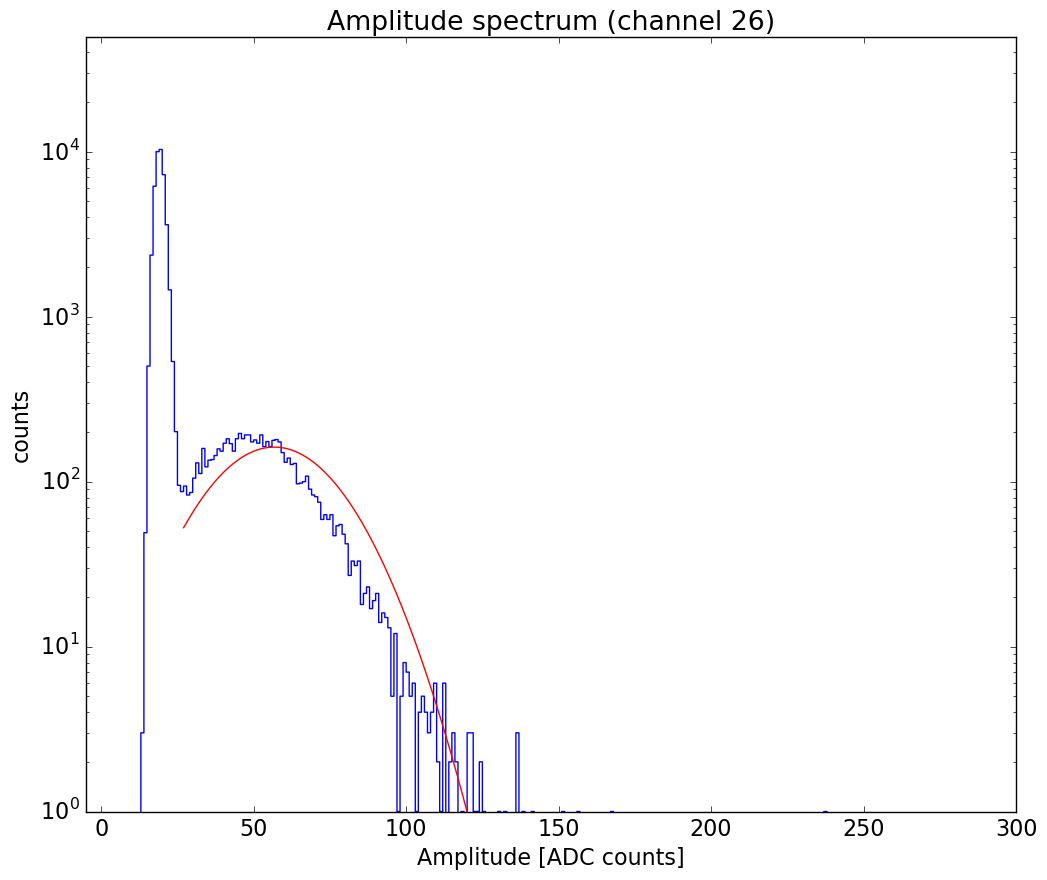

 11%|█         | 27/254 [00:08<01:11,  3.16it/s]

27
channel 27 mean: 17
28
channel 28 mean: 21
29
channel 29 mean: 23
30
channel 30 mean: 30
57
channel 57 mean: 30
58
channel 58 mean: 25
59
channel 59 mean: 27
60
channel 60 mean: 32
61
channel 61 mean: 25
82
channel 82 mean: 38
83
channel 83 mean: 22
84
channel 84 mean: 28
85
channel 85 mean: 26
86
102
channel 102 mean: 26
103
channel 103 mean: 25
104
channel 104 mean: 34
105
channel 105 mean: 39
116
channel 116 mean: 35
117
channel 117 mean: 23
118
channel 118 mean: 45
125
channel 125 mean: 27


In [93]:
spe_means = [] #in order of channels
spe_stds = []
good_channels = []
sketchy_channels = []
noise1_means = []
noise1_stds = []
noise2_means = []
noise2_stds = []

print("number of channels: ", n_channels)
for ch in tqdm(range(n_channels)):
    if ch in show_channels:
        print(ch)
        #plt.subplot(211)
        spectrum = spe_hist.slice(ch, stop=None, axis='channel').project('amplitude')
        if spectrum.mean <= 15:
            sketchy_channels.append(ch)
            continue
        channel = ch
        print('channel %i mean: %i' % (channel, spectrum.mean))
        good_channels.append(ch)
        #data = amplitude_survival.slicesum(ch, ch, 'channel')
        #data.plot(color=cm.spectral(1*show_channels.index(ch)/len(show_channels)), linestyle='-', label='%d'% ch)
    
        #fit the spe spectrum
        #first_guess = [1e1, 3*spectrum.mean, 20]
        #initial_pars, initial_cov = fit_with_gauss(spectrum.bin_centers, spectrum.histogram, 
        #                                          20, 80, first_guess)
        #print(initial_pars)
        #fit_pars, fit_cov = fit_with_gauss(spectrum.bin_centers, spectrum.histogram,
        #                                   initial_pars[1]-0.5*initial_pars[2],
        #                                    initial_pars[1]+2.5*initial_pars[2], 
        #                                    initial_pars)
        
        #spe_means.append(fit_pars[1])
        #spe_stds.append(fit_pars[2])
        #draw_range = np.arange(fit_pars[1] - 1.5*fit_pars[2], fit_pars[1] + 5.5*fit_pars[2], 0.5)
        #fit = [gauss(x, *fit_pars) for x in draw_range]
        
        if ch == board_1_channels[1]:
            #print("test")
            spectrum.plot()
            #plt.plot(draw_range, fit, color='red')
            plt.yscale('log')
            plt.xlim(-5, 300)
            plt.title('Amplitude spectrum (channel %i)' % ch)
            plt.ylim(1, 5e4)
            plt.xlabel('Amplitude [ADC counts]')
            plt.ylabel('counts')
            plt.savefig('example_spe_spectrum.png')
            plt.show()
        


[]

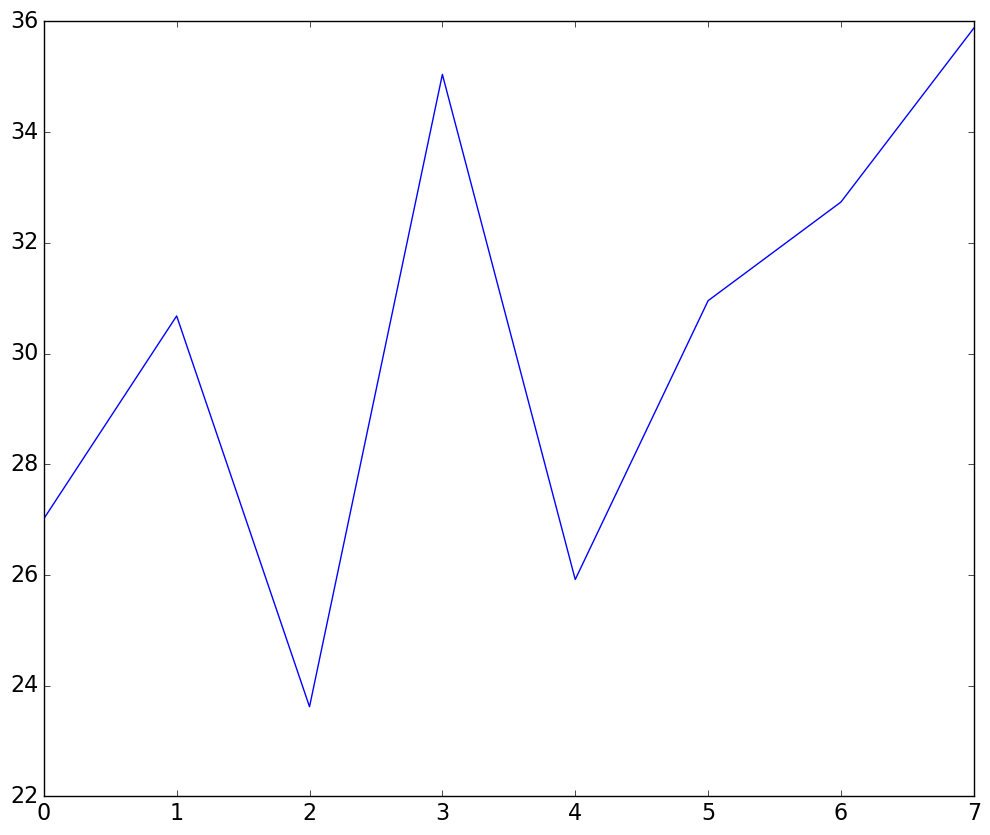

In [52]:
plt.plot(spe_stds)
plt.plot()

In [95]:
%%bash
source activate pax_v5.6.5

/project/lgrandi/anaconda3/envs/pax_head/bin/activate: line 66: sed: No such file or directory


## Now find expected time of the LED pulse

For each channel, plot the time distribution of pulses in the spe amplitude region (mu-sigma -- mu+sigma)



In [53]:
print(sketchy_channels)

[25, 26, 27, 28, 29, 58, 59, 61, 83, 84, 85, 86, 102, 103, 117, 125]


In [17]:
amplitude_bounds = (-100, 2000)
n_channels = 254
n_loop_events = 10000 #nevents

timing_hist = multihist.Histdd(axis_names=['channel', 'peak_sample'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

good_events_seen = 0

def get_events():
    for event in mypax.get_events():
        event = mypax.process_event(event)
        yield event
event_generator = get_events()

for event_i in tqdm(range(n_loop_events)):
    event = next(event_generator)
    if not len(event.pulses) == n_channels:
        # Ignore weird events where not all channels are present
        # These are probably due to a bug in the event builder
        continue
    good_events_seen += 1
    sample_list = np.ones(len(good_channels))
    
    for p in event.pulses:
        if p.channel not in show_channels or p.channel in sketchy_channels:
            continue
        w = p.raw_data
        assert len(w) == samples_per_pulse
        w = np.median(w) - w     # Baseline the waveform by subtracting the median, flip signal
        w = np.clip(w, *amplitude_bounds)
        i = good_channels.index(p.channel)
        #if spe_means[i] - spe_stds[i] < max(w) < spe_means[i]+spe_stds[i]:  #if amlplitude looks like a spe
        if 40 < max(w) < 60:
            sample_list[i] = np.argmax(w)
        else:
            sample_list[i] = -99
            
    timing_hist.add(good_channels, sample_list)

print("%d proper events seen in %d events" % (good_events_seen, n_loop_events))

 90%|████████▉ | 8996/10000 [01:28<00:08, 116.73it/s]INFO:ReadZipped:InputFromFolder: Selecting file /project/lgrandi/xenon1t/raw/161111_1728/XENON1T-4511-000009000-000009999-000001000.zip (number 10/197 in folder) for reading


10000 proper events seen in 10000 events


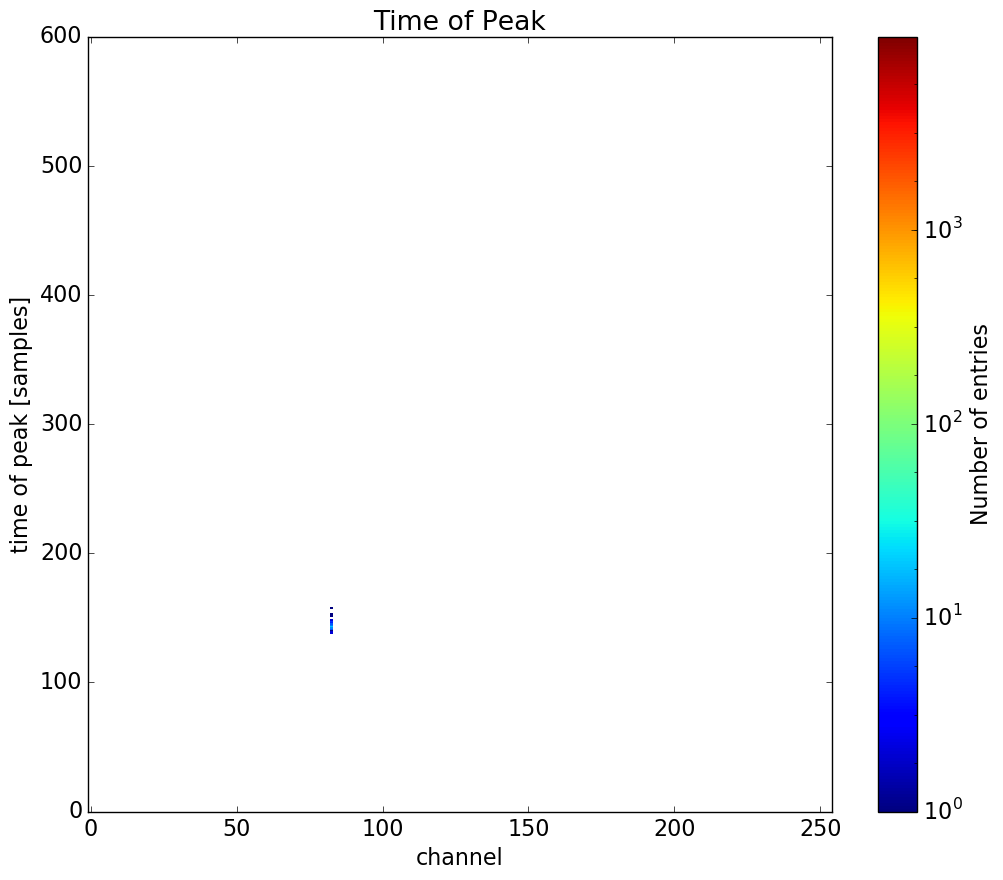

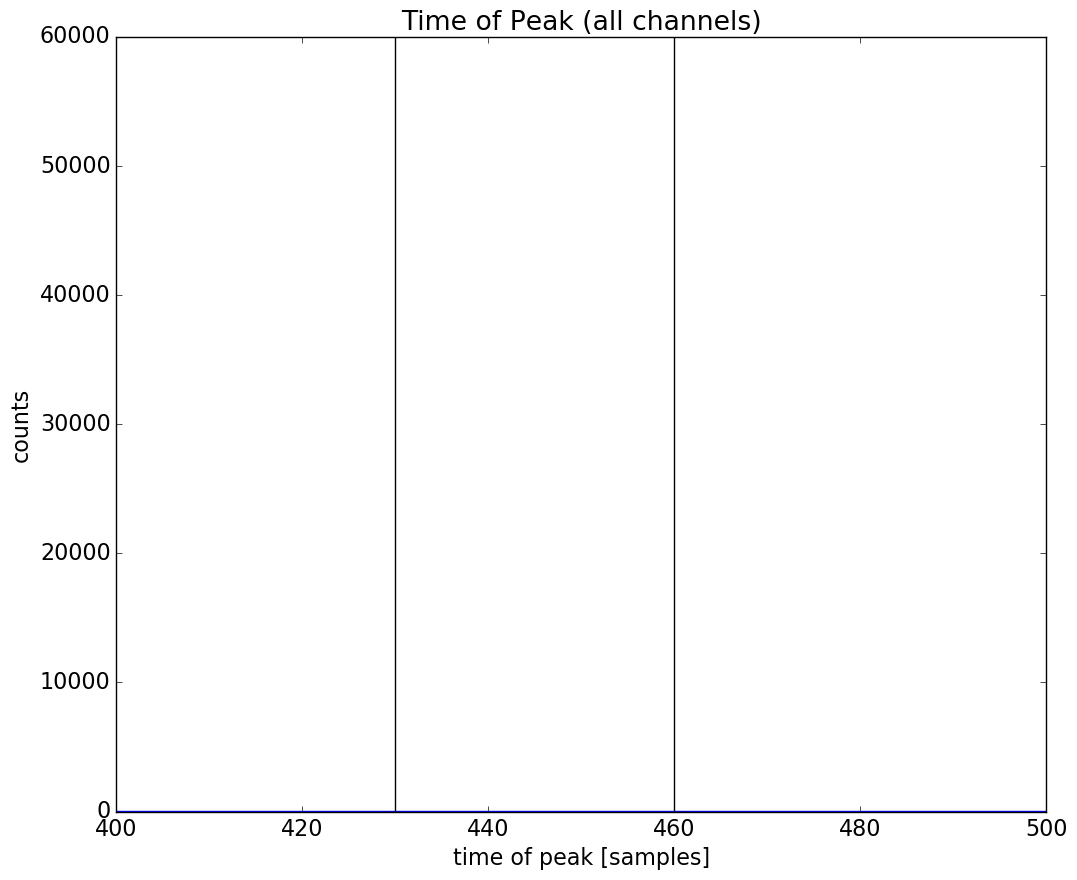

In [18]:
timing_hist.plot(log_scale = True)
plt.ylim(0, 600)
plt.title('Time of Peak')
plt.ylabel('time of peak [samples]')
plt.savefig('timedist.png')
plt.show()

time_dist = timing_hist.project('peak_sample')
time_dist.plot()

plt.xlim(400,500)
plt.ylim(0,60000)

#irst_guess = [1, 100, 10]
#time_fit_par, time_fit_cov = fit_with_gauss(time_dist.bin_centers, time_dist.histogram, 90, 105, first_guess)

#if time_fit_par[2] < 0:
    #time_fit_par[2] = -1*time_fit_par[2]
    
#draw_range = np.arange(time_fit_par[1] - 2*time_fit_par[2], time_fit_par[1]+2*time_fit_par[2],0.5)
#fit = [gauss(x, *time_fit_par) for x in draw_range]
#plt.plot(draw_range, fit, 'r')
plt.ylabel('counts')
plt.xlabel('time of peak [samples]')
plt.title('Time of Peak (all channels)')

plt.plot([430,430],[0, 60000], 'k' )
plt.plot([460,460],[0, 60000], 'k' )
plt.savefig('projected_timedist.png')
plt.show()


### Conservative LED window: [88, 108] samples, or 880-1080 ns. 

Now redo analysis using this window and 4 noise windows of the same width.

### Conservative LED window: [430, 459] samples, or 4300-4590 ns. 

Now redo analysis using this window and 4 noise windows of the same width.

In [80]:
amplitude_bounds = (-100, 1000)
n_channels = 254
n_loop_events = nevents
off_window_start = 152 # see window_watcher.ipynb




noise_hist_samples_1 = multihist.Histdd(axis_names=['channel', 'amplitude'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

spe_hist_samples = multihist.Histdd(axis_names=['channel', 'amplitude'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

noise_hist_max_1 = multihist.Histdd(axis_names=['channel', 'amplitude'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

spe_hist_max = multihist.Histdd(axis_names=['channel', 'amplitude'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

noise_hist_samples_2 = multihist.Histdd(axis_names=['channel', 'amplitude'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))
noise_hist_max_2 = multihist.Histdd(axis_names=['channel', 'amplitude'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

noise_hist_samples_3 = multihist.Histdd(axis_names=['channel', 'amplitude'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))
noise_hist_max_3 = multihist.Histdd(axis_names=['channel', 'amplitude'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

noise_hist_samples_4 = multihist.Histdd(axis_names=['channel', 'amplitude'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))
noise_hist_max_4 = multihist.Histdd(axis_names=['channel', 'amplitude'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

spe_integral = multihist.Histdd(axis_names=['channel', 'charge'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

noise_integral = multihist.Histdd(axis_names=['channel', 'charge'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

noise_no_baseline = multihist.Histdd(axis_names=['channel', 'charge'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

spe_no_baseline = multihist.Histdd(axis_names=['channel', 'charge'],
                              bins=(np.arange(-1, n_channels + 1), 
                                    np.arange(*amplitude_bounds)))

noise_baseline_array = np.ones((len(show_channels), n_loop_events))
LED_baseline_array = np.ones((len(show_channels), n_loop_events))

In [1104]:
import scipy.integrate as integrate

def get_events():
    for event in mypax.get_events():
        event = mypax.process_event(event)
        yield event
event_generator = get_events()

LED_window = [88, 107]
nw_of_interest = [43,62]
window_diff = LED_window[0] - nw_of_interest[0]

noise_events = 0
LED_events = 0
good_events_seen = 0

for event_i in tqdm(range(n_loop_events)):
    event = next(event_generator)
    if not len(event.pulses) == n_channels:
        # Ignore weird events where not all channels are present
        # These are probably due to a bug in the event builder
        continue
        
    good_events_seen += 1
    channel_list = np.ones(len(show_channels))
    noise_amplitude_list_1 = np.ones(len(show_channels))
    noise_amplitude_list_2 = np.ones(len(show_channels))
    noise_amplitude_list_3 = np.ones(len(show_channels))
    noise_amplitude_list_4 = np.ones(len(show_channels))
    spe_amplitude_list = np.ones(len(show_channels))
    
    spe_charge_list = np.ones(len(show_channels))
    noise_charge_list = np.ones(len(show_channels))
    
    counter = 0
    for p in event.pulses:
        #if p.channel != show_channels[0]:
            #continue
        if p.channel not in show_channels:
            continue
        w = p.raw_data
        assert len(w) == samples_per_pulse
        noise_baseline = w[0:(200-window_diff)]
        LED_baseline = w[window_diff:]
        
        noise_baseline_array[counter, event_i] *= np.median(noise_baseline) 
        LED_baseline_array[counter, event_i] *= np.median(LED_baseline) 
        
        assert not np.array_equal(noise_baseline, LED_baseline)

        #noise_no_baseline.add(np.ones(len(noise_baseline))*p.channel, noise_baseline)
        #spe_no_baseline.add(np.ones(len(LED_baseline))*p.channel, LED_baseline)
        
        noise_w = np.median(noise_baseline) - w     # Baseline the waveform by subtracting the median, flip signal
        spe_w = np.median(LED_baseline) - w

        
        spe = spe_w[88:107]            # consider LED window only
        spe = np.clip(spe, *amplitude_bounds)        
        
        #for noise subtraction, consider different windows
        noise1 = noise_w[43:62]
        noise2 = noise_w[35:54]
        noise3 = noise_w[51:70]
        noise4 = noise_w[22:41]
        noise1 = np.clip(noise1, *amplitude_bounds)
        noise2 = np.clip(noise2, *amplitude_bounds)
        noise3 = np.clip(noise3, *amplitude_bounds)
        noise4 = np.clip(noise4, *amplitude_bounds)
        
        
        LED_charge = integrate.simps(spe)
        noise1_charge = integrate.simps(noise1)
        
        
        assert len(noise1) == len(spe) == len(noise2) == len(noise3) == len(noise4)
        channel_list[counter] = p.channel
        
        noise_amplitude_list_1[counter] = max(noise1)
        noise_amplitude_list_2[counter] = max(noise2)
        noise_amplitude_list_3[counter] = max(noise3)
        noise_amplitude_list_4[counter] = max(noise4)
        spe_amplitude_list[counter] = max(spe)
        
        noise_charge_list[counter] = noise1_charge
        spe_charge_list[counter] = LED_charge
        
        counter+=1
        
    if (event_i >= off_window_start):    
        noise_hist_max_1.add(channel_list, noise_amplitude_list_1)
        noise_hist_max_2.add(channel_list, noise_amplitude_list_2)
        noise_hist_max_3.add(channel_list, noise_amplitude_list_3)
        noise_hist_max_4.add(channel_list, noise_amplitude_list_4)
        noise_integral.add(channel_list, noise_charge_list)
        noise_events += 1
        
    if (event_i < n_loop_events - off_window_start):
        spe_hist_max.add(channel_list, spe_amplitude_list)
        spe_integral.add(channel_list, spe_charge_list)
        LED_events += 1
                

print("%d proper events seen in %d events" % (good_events_seen, n_loop_events))
print("noise entries:", noise_events)
print("spe entries:", LED_events)

114226 proper events seen in 114234 events
noise entries: 114074
spe entries: 114082


# Noise and LED Amplitudes

We have 0.0228 sec per channel, so rates below 43.8 Hz are definitely unrealiable!
The total event rate is 5000000.0000


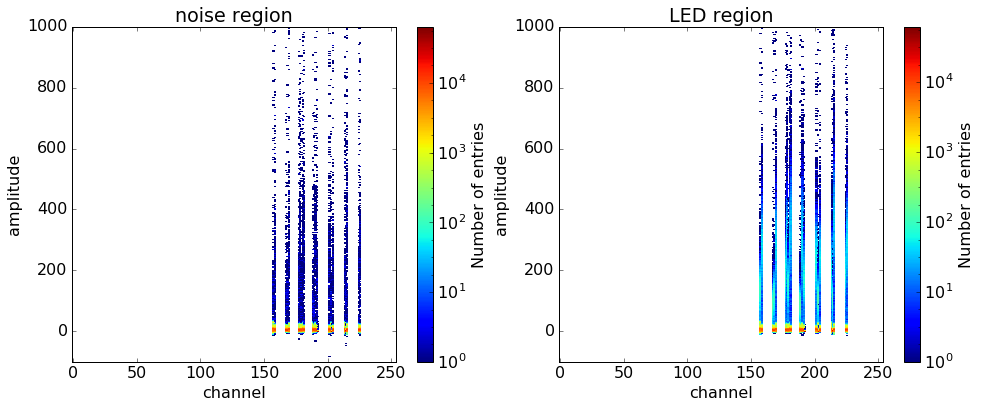

In [1105]:
time_per_channel = good_events_seen * 20 * 10 * units.ns #samples_pee_pulse * 10 * units.ns
total_event_rate = good_events_seen / (time_per_channel / 1.0e9)
max_rate_hz = 1/time_per_channel / units.Hz

print("We have %0.4f sec per channel, so rates below %0.1f Hz are definitely unrealiable!" %
      (time_per_channel / units.s, max_rate_hz))

print("The total event rate is %0.4f" % total_event_rate)

plt.figure(figsize = (16, 6))
plt.subplot(121)
noise_hist_max_1.plot(log_scale = True)
plt.title('noise region')

plt.subplot(122)
spe_hist_max.plot(log_scale = True)
plt.title('LED region')
plt.show()

# Noise and LED Integrated Charge

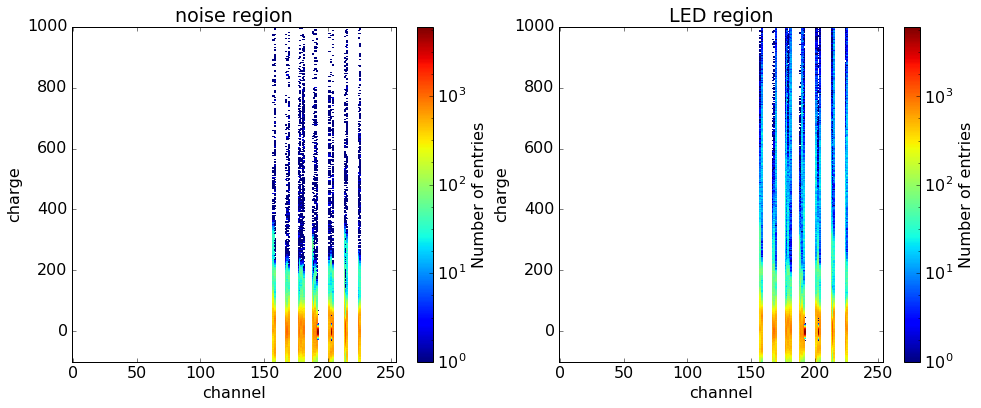

In [1106]:
plt.figure(figsize = (16, 6))
plt.subplot(121)
noise_integral.plot(log_scale = True)
plt.title('noise region')

plt.subplot(122)
spe_integral.plot(log_scale = True)
plt.title('LED region')
plt.show()

In [1195]:
noise_amplitude_survival_1 = noise_hist_max_1.cumulative_density('amplitude')
noise_amplitude_survival_1.histogram = 1 - noise_amplitude_survival_1.histogram
noise_amplitude_survival_1.histogram *= noise_hist_max_1.project('channel').histogram[:, np.newaxis] #/ time_per_channel / units.Hz

noise_amplitude_survival_2 = noise_hist_max_2.cumulative_density('amplitude')
noise_amplitude_survival_2.histogram = 1 - noise_amplitude_survival_2.histogram
noise_amplitude_survival_2.histogram *= noise_hist_max_2.project('channel').histogram[:, np.newaxis] #/ time_per_channel / units.Hz

noise_amplitude_survival_3 = noise_hist_max_3.cumulative_density('amplitude')
noise_amplitude_survival_3.histogram = 1 - noise_amplitude_survival_3.histogram
noise_amplitude_survival_3.histogram *= noise_hist_max_3.project('channel').histogram[:, np.newaxis] #/ time_per_channel / units.Hz

noise_amplitude_survival_4 = noise_hist_max_4.cumulative_density('amplitude')
noise_amplitude_survival_4.histogram = 1 - noise_amplitude_survival_4.histogram
noise_amplitude_survival_4.histogram *= noise_hist_max_4.project('channel').histogram[:, np.newaxis] #/ time_per_channel / units.Hz


spe_amplitude_survival = spe_hist_max.cumulative_density('amplitude')
spe_amplitude_survival.histogram = 1 - spe_amplitude_survival.histogram
spe_amplitude_survival.histogram *= spe_hist_max.project('channel').histogram[:, np.newaxis] #/ time_per_channel / units.Hz

average_noise_spectrum = multihist.Hist1d(bins=np.arange(*amplitude_bounds))



off_channels = []
for ch in range(n_channels):
    if ch not in show_channels:
        continue
    spe_spectrum = spe_hist_max.slice(ch,ch,'channel').project('amplitude')
    if spe_spectrum.mean <= 5:
        off_channels.append(ch)
    
print("off channels:", off_channels)

off channels: [192, 203]


# Some data handling

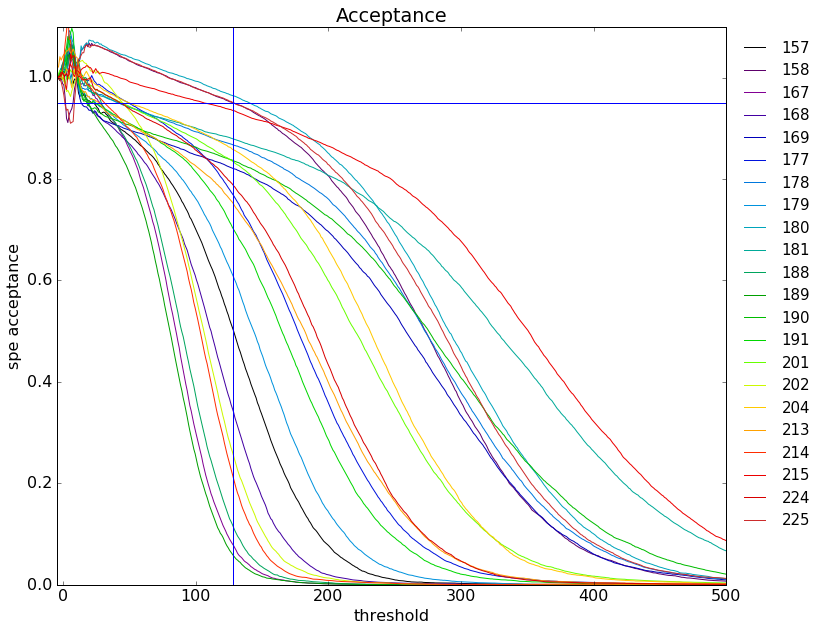

In [1270]:
DEBUG = False
accepts_list = np.arange(0.05, 1, 0.05)

f = open(output_file, 'w')
f.write("ch")
for a in accepts_list:
    f.write("," + str(a))
f.write("\n")

def find_threshold(hist1d, acc_frac):
    acceptance = 1 - hist1d.cumulative_density
    bin0 = np.where(hist1d.bin_edges == 0)[0][0]
    diff = np.absolute(acceptance - acc_frac)
    thresh = np.where(diff == min(diff))[0][0]
    return (thresh - bin0)

for ch in tqdm(range(n_channels)):
    if ch in off_channels:
        continue
    if ch in show_channels:
        #print(ch)
        channel = ch
        data = amplitude_survival.slicesum(ch, ch, 'channel')
        data2 = spe_amplitude_survival.slicesum(ch, ch, 'channel')
        
        spe_spectrum = spe_hist_max.slice(ch,ch,'channel').project('amplitude')
        noise_spectrum_1 = noise_hist_max_1.slice(ch,ch,'channel').project('amplitude')
        noise_spectrum_2 = noise_hist_max_2.slice(ch,ch,'channel').project('amplitude')
        noise_spectrum_3 = noise_hist_max_3.slice(ch,ch,'channel').project('amplitude')
        noise_spectrum_4 = noise_hist_max_4.slice(ch,ch,'channel').project('amplitude')
        
        spe_charge_spectrum = spe_integral.slice(ch,ch,'channel').project('charge')
        noise_charge_spectrum = noise_integral.slice(ch,ch,'channel').project('charge')
        
        residual_charge_spectrum = spe_charge_spectrum - noise_charge_spectrum
    
        average_noise_spectrum.histogram = np.ones(len(noise_spectrum_1.histogram))
        
        for b in range(len(noise_spectrum_1.histogram)):
            mean = np.mean([float(noise_spectrum_1.histogram[b]), 
                            float(noise_spectrum_2.histogram[b]),
                            float(noise_spectrum_3.histogram[b]),
                            float(noise_spectrum_4.histogram[b])])
            
            average_noise_spectrum.histogram[b] *= mean  
        
        noise1_errors = np.sqrt(noise_spectrum_1.histogram)
        spe_errors = np.sqrt(spe_spectrum.histogram)
            
        bin0 = np.where(spe_charge_spectrum.bin_edges == 0)[0][0]
        spe_charge_first10 = spe_charge_spectrum.histogram[bin0:(bin0+10)].sum()
        noise_charge_first10 = noise_charge_spectrum.histogram[bin0:(bin0+10)].sum()
        
        spe_amp_first10 = spe_spectrum.histogram[bin0:(bin0+10)].sum()
        noise_amp_first10 = noise_spectrum_1.histogram[bin0:(bin0+10)].sum()
        correction = spe_amp_first10/noise_amp_first10
        
        noise_spectrum_1.histogram = correction * noise_spectrum_1
        noise1_errors *= correction
        
        residual_spectrum = spe_spectrum - noise_spectrum_1
        residual_errors = np.sqrt(noise1_errors**2 + spe_errors**2)

        
        in_errors = True
        starter_bin = np.where(average_noise_spectrum.bin_edges == 0)[0] - 1
        while not in_errors:
            starter_bin += 1
            in_errors = (noise_spectrum_1.histogram[starter_bin] - noise1_errors[starter_bin] <=
                         spe_spectrum.histogram[starter_bin] + spe_errors[starter_bin]) and (spe_spectrum.bin_centers[starter_bin] >= 12)
            
            #print(average_noise_spectrum.histogram[starter_bin], average_noise_errors[starter_bin],
             #            spe_spectrum.histogram[starter_bin], spe_errors[starter_bin])
            residual_spectrum.histogram[starter_bin] = 0
 
        #data.plot(color = 'red')
        #print(data2.histogram)
        #data2.plot(color = 'black')
        #data.plot(color=cm.spectral(1*board_1_channels.index(ch)/len(board_1_channels)), linestyle='-', label='%d'% ch)
        
        #plt.subplot(211)
        spe_acceptance = spe_amplitude_survival.slice(ch,ch,'channel').project('amplitude')
        
        
        noise_acceptance = correction * noise_amplitude_survival_1.slice(ch,ch,'channel').project('amplitude') 

        
        residual_acceptance = spe_acceptance - noise_acceptance
        max_T = np.argmax(residual_acceptance.histogram)
        residual_acceptance = residual_acceptance / residual_acceptance[max_T]
        
        if DEBUG:
            fig = plt.figure(figsize = (16,8))
            plt.subplot(121)            
            spe_spectrum.plot(color = 'red', errors = True, label = 'LED window')
            noise_spectrum_1.plot(color = cm.Greys(0.3), errors = True, label = 'noise window 1')
            noise_spectrum_2.plot(color = cm.Greys(0.5), errors = True, label = 'noise window 2')
            noise_spectrum_3.plot(color = cm.Greys(0.7), errors = True, label = 'noise window 3')
            noise_spectrum_4.plot(color = cm.Greys(0.9), errors = True, label = 'noise window 4')


            plt.yscale('log')
            plt.xlim(0,500)
            plt.ylim(0.1,1e6)
            plt.title('amplitude spectra')
            plt.xlabel('amplitude')
            plt.ylabel('counts')
            #plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 15, frameon=False)
            plt.legend(loc='upper right',  fontsize = 15, frameon=False)
            plt.grid(b=True, which='both', color='0.65',linestyle='-')

            plt.subplot(122)
            spe_spectrum.plot(color = 'red', errors = True, label = 'LED window')
            noise_spectrum_1.plot(color = cm.Greys(0.3), errors = True, label = 'noise window 1')
            #noise_spectrum_2.plot(color = cm.Greys(0.5), errors = True, label = 'noise window 2')
            #noise_spectrum_3.plot(color = cm.Greys(0.7), errors = True, label = 'noise window 3')
            #noise_spectrum_4.plot(color = cm.Greys(0.9), errors = True, label = 'noise window 4')
            plt.yscale('log')
            plt.xlim(0,40)
            plt.ylim(1e2,2e4)
            plt.title('amplitude spectra')
            plt.xlabel('amplitude')
            plt.ylabel('counts')
            #plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 15, frameon=False)
            plt.legend(loc='upper right',  fontsize = 15, frameon=False)
            plt.grid(b=True, which='both', color='0.65',linestyle='-')
            plt.show()
            
            #residual_spectrum.plot()
            plt.errorbar(residual_spectrum.bin_centers, residual_spectrum.histogram, yerr = residual_errors, 
                         ecolor='b', marker = '.', linestyle = 'None')
            plt.yscale('linear')
            plt.xlim(0,100)
            #plt.ylim(-50, 300)
            plt.title('residual spectrum (massaged)')
            plt.xlabel('amplitude')
            plt.ylabel('residual counts')
            plt.grid(b=True, which='both', color='0.65',linestyle='-')
            plt.show()
        
        f.write(str(ch))
        for a in accepts_list:
            T = find_threshold(residual_spectrum, a)
            f.write("," + str(T))
        f.write("\n")
            
            
        residual_cum = residual_spectrum.cumulative_density
        residual_cum = 1 - residual_cum
        #residual_cum *= residual_spectrum.histogram[]
        plt.plot(residual_spectrum.bin_centers, residual_cum,color = cm.spectral(1*show_channels.index(ch)/len(show_channels)), label = '%i'%ch)
        #residual_acceptance.plot(color = cm.spectral(1*show_channels.index(ch)/len(show_channels)))
        plt.xlim(-5,500)
        plt.ylim(0,1.1)
        plt.title('Acceptance')

plt.xlabel('threshold')
plt.ylabel('spe acceptance')
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1), fontsize = 15, frameon=False)
plt.plot([thresh_90, thresh_90], [0, 1.1], color = 'blue')
plt.plot([-5,500], [0.95,0.95])
plt.show()
#board_7_channels = [157, 158,
#                    167, 168, 169,
#                    177, 178, 179, 180, 181,
#                    188, 189, 190, 191, 192,
#                    201, 202, 203, 204,
#                    213, 214, 215,
#                    224, 225]        
#color = cm.spectral(1*show_channels.index(ch)/len(show_channels))

In [1280]:
fread = open("1600V_board7_thresholds.csv")

header = fread.readline().rstrip().split(',')
header.pop(0)
acceptance_list = [float(i) for i in header]
acceptance_list
    

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

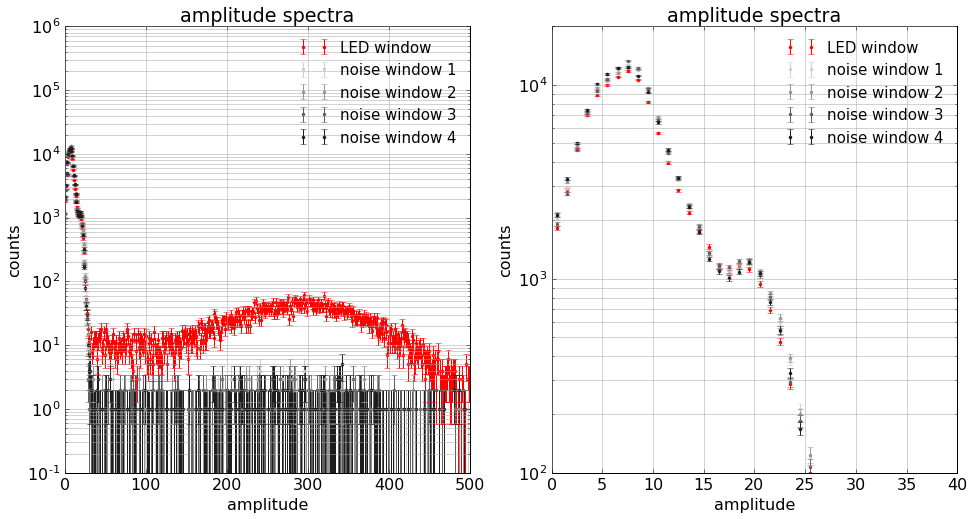

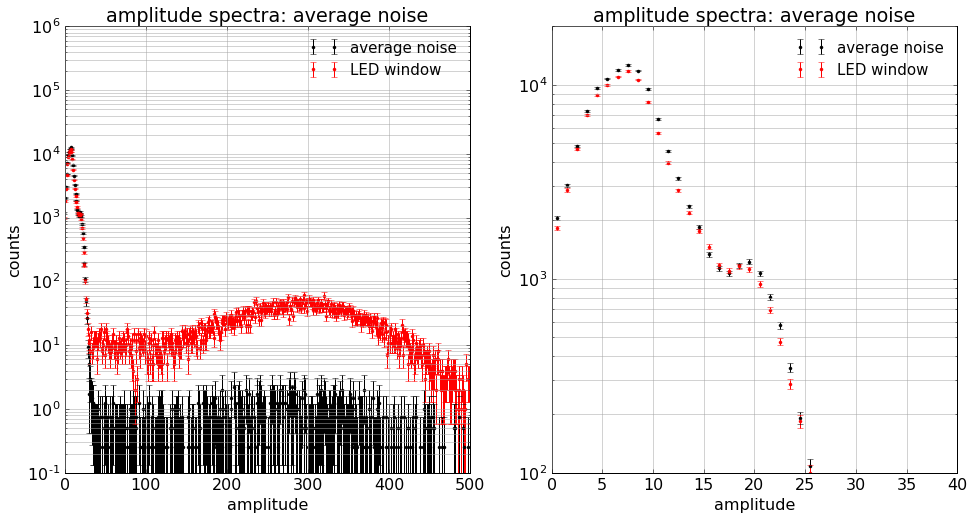

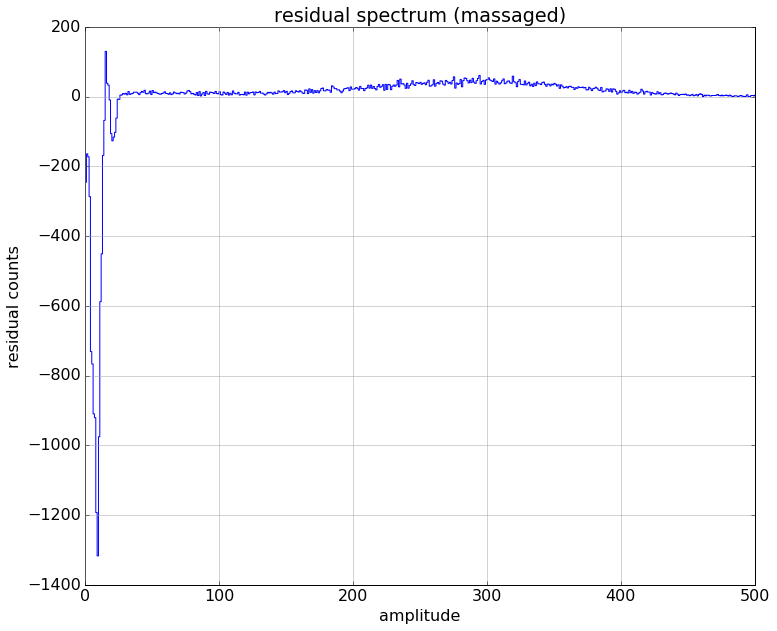

In [1014]:
        fig = plt.figure(figsize = (16,8))
        plt.subplot(121)
        
            
        spe_spectrum.plot(color = 'red', errors = True, label = 'LED window')
        noise_spectrum_1.plot(color = cm.Greys(0.3), errors = True, label = 'noise window 1')
        noise_spectrum_2.plot(color = cm.Greys(0.5), errors = True, label = 'noise window 2')
        noise_spectrum_3.plot(color = cm.Greys(0.7), errors = True, label = 'noise window 3')
        noise_spectrum_4.plot(color = cm.Greys(0.9), errors = True, label = 'noise window 4')


        plt.yscale('log')
        plt.xlim(0,500)
        plt.ylim(0.1,1e6)
        plt.title('amplitude spectra')
        plt.xlabel('amplitude')
        plt.ylabel('counts')
        #plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 15, frameon=False)
        plt.legend(loc='upper right',  fontsize = 15, frameon=False)
        plt.grid(b=True, which='both', color='0.65',linestyle='-')
        
        plt.subplot(122)
        spe_spectrum.plot(color = 'red', errors = True, label = 'LED window')
        noise_spectrum_1.plot(color = cm.Greys(0.3), errors = True, label = 'noise window 1')
        noise_spectrum_2.plot(color = cm.Greys(0.5), errors = True, label = 'noise window 2')
        noise_spectrum_3.plot(color = cm.Greys(0.7), errors = True, label = 'noise window 3')
        noise_spectrum_4.plot(color = cm.Greys(0.9), errors = True, label = 'noise window 4')
        plt.yscale('log')
        plt.xlim(0,40)
        plt.ylim(1e2,2e4)
        plt.title('amplitude spectra')
        plt.xlabel('amplitude')
        plt.ylabel('counts')
        #plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 15, frameon=False)
        plt.legend(loc='upper right',  fontsize = 15, frameon=False)
        plt.grid(b=True, which='both', color='0.65',linestyle='-')
        plt.show()
        
        fig = plt.figure(figsize = (16,8))
        plt.subplot(121)
        average_noise_spectrum.plot(color = 'black', label = 'average noise', errors = True)
        spe_spectrum.plot(color = 'red', label = 'LED window', errors = True)
        plt.yscale('log')
        plt.xlim(0,500)
        plt.ylim(0.1,1e6)
        plt.title('amplitude spectra: average noise')
        plt.xlabel('amplitude')
        plt.ylabel('counts')
        #plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 15, frameon=False)
        plt.legend(loc='upper right',  fontsize = 15, frameon=False)
        plt.grid(b=True, which='both', color='0.65',linestyle='-')
        #plt.show()
        
        
        plt.subplot(122)
        average_noise_spectrum.plot(color = 'black', label = 'average noise', errors = True)
        spe_spectrum.plot(color = 'red', label = 'LED window', errors = True)
        plt.yscale('log')
        plt.xlim(0,40)
        plt.ylim(1e2,2e4)
        plt.title('amplitude spectra: average noise')
        plt.xlabel('amplitude')
        plt.ylabel('counts')
        #plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 15, frameon=False)
        plt.legend(loc='upper right',  fontsize = 15, frameon=False)
        plt.grid(b=True, which='both', color='0.65',linestyle='-')
        plt.show()
        
        #print("starter bin: ", starter_bin)
        residual_spectrum.plot()
        plt.yscale('linear')
        plt.xlim(0,500)
        #plt.ylim(-50, 300)
        plt.title('residual spectrum (massaged)')
        plt.xlabel('amplitude')
        plt.ylabel('residual counts')
        plt.grid(b=True, which='both', color='0.65',linestyle='-')
        plt.show()
        


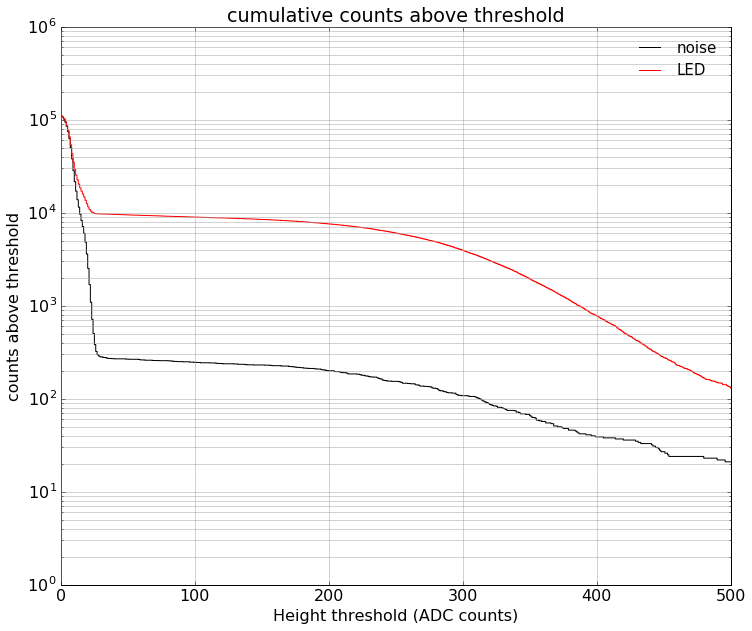

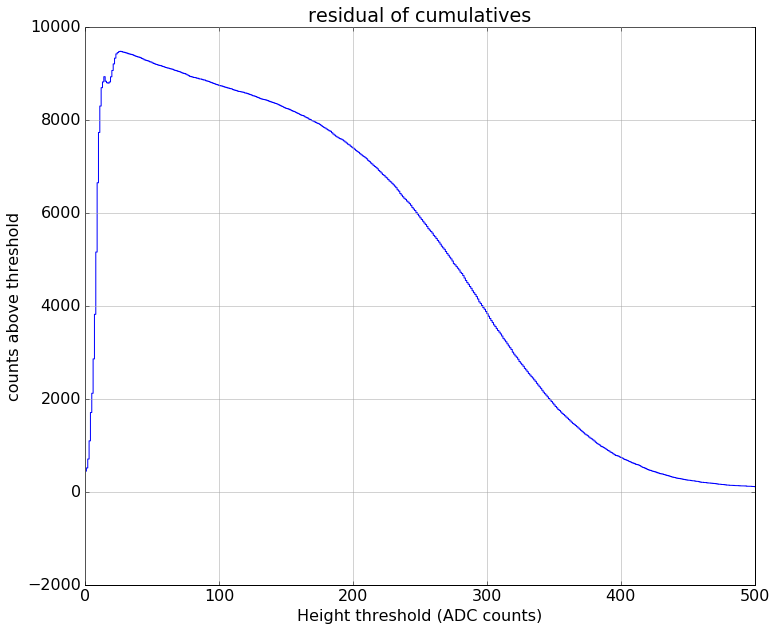

In [1007]:
xlimits = (0,500)
ylimits = (5e1,2e5)        
      
noise_acceptance.plot(color = 'black', label = 'noise')
spe_acceptance.plot(color = 'red', label = 'LED')
#plt.subplot(211)
plt.yscale('log')
plt.ylim(1, 1e6)
plt.xlabel('Height threshold (ADC counts)')
plt.ylabel('counts above threshold')
plt.xlim(*xlimits)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.legend(loc='upper right', fontsize = 15, frameon=False)
plt.title('cumulative counts above threshold')
#plt.title("Noise amplitude distribution for channels on Board 1")
#plt.savefig("Filter_Box_Test_output/amplitudes_board_1_zoom_Run173.png")
#plt.savefig("%samplitudes_board_1_zoom.png" %output_prefix)
plt.show()
        
#plt.subplot(212)
residual_acceptance.plot()
plt.yscale('linear')
#plt.ylim(-100, 100)
plt.xlim(0,500)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.title('residual of cumulatives')
plt.xlabel('Height threshold (ADC counts)')
plt.ylabel('counts above threshold')
plt.show()
        

               


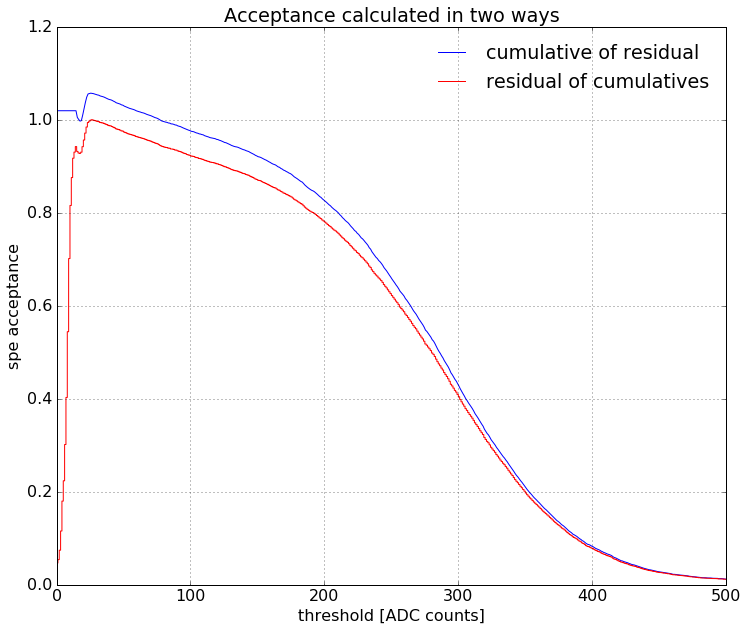

In [1012]:
ch = show_channels[2]

for ch in tqdm(range(n_channels)):
    if ch in show_channels:
        max_T = np.argmax(residual_acceptance.histogram)


residual_cum = residual_spectrum.cumulative_density
residual_cum = 1 - residual_cum
#residual_cum *= residual_spectrum.histogram[]
plt.plot(residual_spectrum.bin_centers, residual_cum, color = 'blue', label = 'cumulative of residual')
plt.xlim(0,500)
#plt.ylim(0,1.1)
plt.title('Acceptance calculated in two ways')

#plt.xlabel('amplitude')
plt.ylabel('spe acceptance')
#plt.show()

spe_acceptance_fraction = residual_acceptance / residual_acceptance[max_T]
spe_acceptance_fraction.plot(color = 'red', label = 'residual of cumulatives')
plt.yscale('linear')
plt.xlim(0,500)
plt.ylim(0,1.2)
#plt.title('Method 2: residual of cumulatives')
#plt.ylabel('spe acceptance')
plt.xlabel('threshold [ADC counts]')
plt.legend(loc = 'upper right', frameon = False)
plt.grid(b = True)
plt.show()
        

#residual_acceptance.plot()
#plt.ylim(1500, 2500)
#plt.xlim(0,50)
#plt.show()

#normalize to get acceptance fraction



114075.0 114070.0


5.0

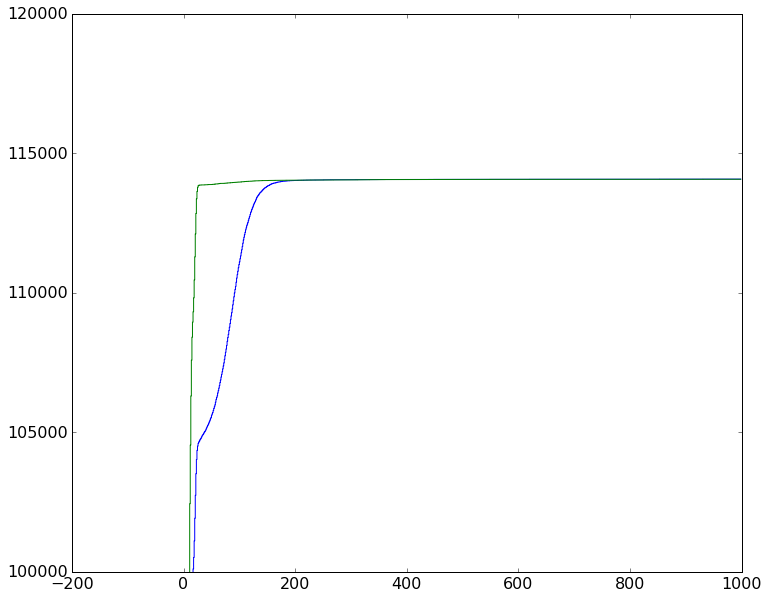

In [981]:
ch = show_channels[2]

spe_cumulative = spe_hist_max.slice(ch,ch,'channel').project('amplitude')
noise_cumulative = noise_hist_max_1.slice(ch,ch,'channel').project('amplitude')

spe_cumulative.histogram = spe_cumulative.cumulative_histogram
noise_cumulative.histogram = noise_cumulative.cumulative_histogram

spe_cumulative.plot()
noise_cumulative.plot()
plt.ylim(1e5,1.2e5)

print(spe_cumulative.histogram[-1], noise_cumulative.histogram[-1])
spe_cumulative.histogram[-2] - noise_cumulative.histogram[-2]


## two methods of calculating spe acceptance


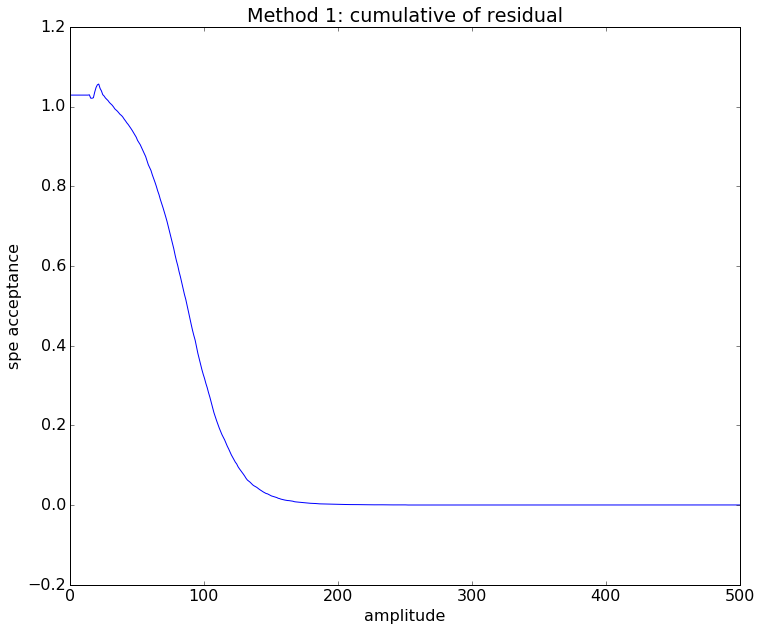

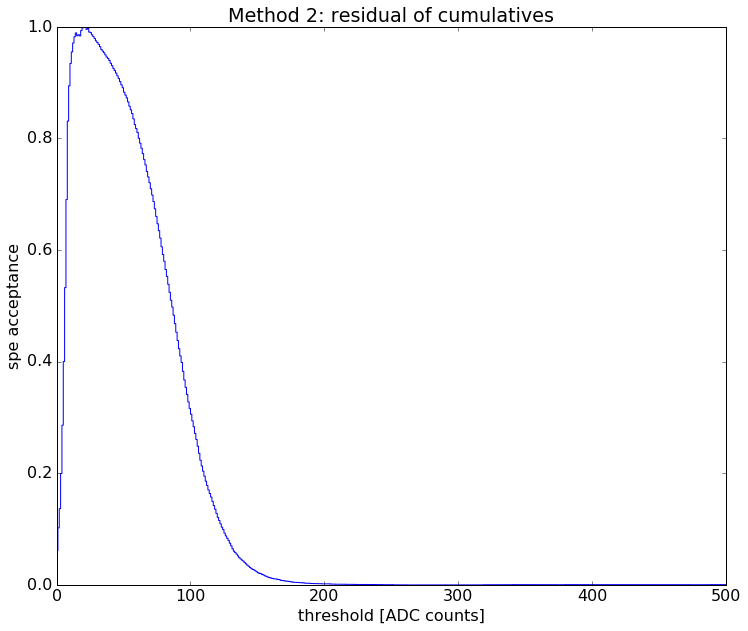

# Next steps:
 # 1.  Not trivial at the moment how to define where the spe signal begins - this significantly alters what we determine to be the acceptance (see above).
 # 2. Once confident that we understand low threshold stuff, need to do this same thing for every channel and at multiple PMT biases. 



In [ ]:
# fit function

gauss_range = [5, 15]
draw_gauss = [0, 25]


def qnorm(T, const, mu, sigma):
    q = const*(1 - erf((T-mu)/(sigma*np.sqrt(2)))) 
    return q


# fit data with qnorm, qexp defined above


gauss_data = []
exp_data = []
overall_data = []

for i, rate in enumerate(data.histogram):
    if gauss_range[0] < data.bin_centers[i] < gauss_range[1]:
        gauss_data.append(rate)
    if exp_range[0] < data.bin_centers[i] < exp_range[1]:
        exp_data.append(rate)
    if overall_fit_range[0] < data.bin_centers[i] < overall_fit_range[1]:
        overall_data.append(rate)
        
gauss_thresholds = [x for x in data.bin_centers if gauss_range[0]<x<gauss_range[1]]
exp_thresholds = [x for x in data.bin_centers if exp_range[0]<x<exp_range[1]]
overall_thresholds = [x for x in data.bin_centers if overall_fit_range[0]<x<overall_fit_range[1]]

assert len(gauss_thresholds)==len(gauss_data)
assert len(exp_thresholds)==len(exp_data)
assert len(overall_thresholds)==len(overall_data)

#plt.plot(gauss_thresholds, gauss_data)


#first_guess = [1.0e8, 0, 20]
first_guess_gauss = [1.0e8, 0.0, 5.0]
fit_pars, fit_cov = curve_fit(qnorm, gauss_thresholds, gauss_data, first_guess_gauss)

first_guess_exp = [1.0e10, -1.0]
exp_fit_pars, exp_fit_cov = curve_fit(qexp, exp_thresholds, exp_data, first_guess_exp)

first_guess_total_fit = np.append(fit_pars, exp_fit_pars)

overall_fit_pars, overall_fit_cov = curve_fit(fit_sum, overall_thresholds, overall_data, first_guess_total_fit)

sumfit_pars = np.append(fit_pars, exp_fit_pars)

print("Gaussian fit parameters(const, mu, sigma): ", fit_pars)
print("Exponential fit parameters(const, mean): ", exp_fit_pars)

print("Fit parameters (gauss0, gauss1, gauss2, exp0, exp1) from overall fit:", overall_fit_pars)

qdata = [qnorm(x, *fit_pars) for x in np.arange(draw_gauss[0], draw_gauss[1], 0.1)]

exp_fit_line = [qexp(x, *exp_fit_pars) for x in np.arange(draw_exp[0], draw_exp[1], 0.1)]

#sumfit_line = [fit_sum(x, *sumfit_pars) for x in np.arange(overall_draw_range[0], overall_draw_range[1], 0.1)]
sumfit_line = [fit_sum(x, *overall_fit_pars) for x in np.arange(overall_draw_range[0], overall_draw_range[1], 0.1)]

thresholds = data.bin_centers
rates = data.histogram

fit = plt.plot(np.arange(draw_gauss[0], draw_gauss[1],0.1), qdata, 'b')
fit2 = plt.plot(np.arange(draw_exp[0], draw_exp[1],0.1), exp_fit_line, 'r')
sumfit = plt.plot(np.arange(overall_draw_range[0], overall_draw_range[1], 0.1), sumfit_line, 'g')

real_points = plt.plot(thresholds, rates, 'ko')

plt.yscale('log')
plt.ylim(1e3, 1e8)
plt.xlabel('Height threshold (ADC counts)')
plt.ylabel('Rate above threshold (Hz)')
plt.xlim(0, 50)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 15, frameon=False)
plt.title("Noise amplitude distribution for channels on Board 1")
#plt.savefig("Filter_Box_Test_output/amplitudes_board_1_zoom_Run173.png")
plt.show()



Gaussian fit parameters(const, mu, sigma):  [  2.52452252e+07   1.52955197e+00   5.76918322e+00]
Exponential fit parameters(const, mean):  [  9.41026716e+04  -1.60053865e-02]
Fit parameters (gauss0, gauss1, gauss2, exp0, exp1) from overall fit: [  6.94920100e+06   7.64826781e+00   3.71101843e+00   6.04518031e+04
  -2.15320079e-03]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


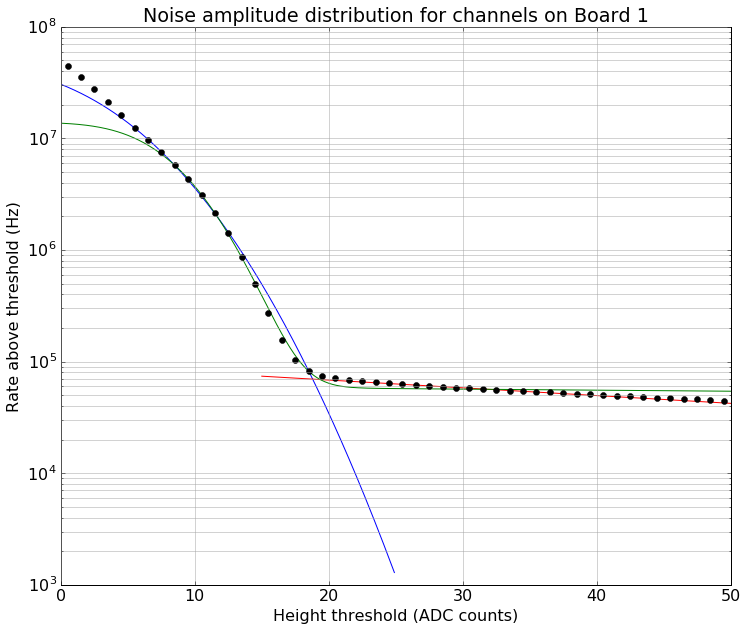

In [318]:
# fit function

from scipy.optimize import curve_fit
from scipy.special import erf, factorial

gauss_range = [5, 15]
exp_range = [25,35]
overall_fit_range = [8, 40]

draw_gauss = [0, 25]
draw_exp = [15, 100]
overall_draw_range = [0, 100]


#def qnorm(T, const1, const2, mu2, sigma1, sigma2):
#    q = const1*sigma1*np.sqrt(np.pi/2.)*(1 - erf((T)/(sigma1*np.sqrt(2)))) + const2*sigma2*np.sqrt(np.pi/2.)*(1 - erf((T-mu2)/(sigma2*np.sqrt(2)))) 
#    return q

def qnorm(T, const, mu, sigma):
    q = const*(1 - erf((T-mu)/(sigma*np.sqrt(2)))) 
    return q

def qexp(T, const, mean):
    q = const * np.exp(mean * T)
    return q

def fit_sum(T, gauss0, gauss1, gauss2, exp0, exp1):
    val = qnorm(T, gauss0, gauss1, gauss2) + qexp(T, exp0, exp1) 
    return val

# fit data with qnorm, qexp defined above


gauss_data = []
exp_data = []
overall_data = []

for i, rate in enumerate(data.histogram):
    if gauss_range[0] < data.bin_centers[i] < gauss_range[1]:
        gauss_data.append(rate)
    if exp_range[0] < data.bin_centers[i] < exp_range[1]:
        exp_data.append(rate)
    if overall_fit_range[0] < data.bin_centers[i] < overall_fit_range[1]:
        overall_data.append(rate)
        
gauss_thresholds = [x for x in data.bin_centers if gauss_range[0]<x<gauss_range[1]]
exp_thresholds = [x for x in data.bin_centers if exp_range[0]<x<exp_range[1]]
overall_thresholds = [x for x in data.bin_centers if overall_fit_range[0]<x<overall_fit_range[1]]

assert len(gauss_thresholds)==len(gauss_data)
assert len(exp_thresholds)==len(exp_data)
assert len(overall_thresholds)==len(overall_data)

#plt.plot(gauss_thresholds, gauss_data)


#first_guess = [1.0e8, 0, 20]
first_guess_gauss = [1.0e8, 0.0, 5.0]
fit_pars, fit_cov = curve_fit(qnorm, gauss_thresholds, gauss_data, first_guess_gauss)

first_guess_exp = [1.0e10, -1.0]
exp_fit_pars, exp_fit_cov = curve_fit(qexp, exp_thresholds, exp_data, first_guess_exp)

first_guess_total_fit = np.append(fit_pars, exp_fit_pars)

overall_fit_pars, overall_fit_cov = curve_fit(fit_sum, overall_thresholds, overall_data, first_guess_total_fit)

sumfit_pars = np.append(fit_pars, exp_fit_pars)

print("Gaussian fit parameters(const, mu, sigma): ", fit_pars)
print("Exponential fit parameters(const, mean): ", exp_fit_pars)

print("Fit parameters (gauss0, gauss1, gauss2, exp0, exp1) from overall fit:", overall_fit_pars)

qdata = [qnorm(x, *fit_pars) for x in np.arange(draw_gauss[0], draw_gauss[1], 0.1)]

exp_fit_line = [qexp(x, *exp_fit_pars) for x in np.arange(draw_exp[0], draw_exp[1], 0.1)]

#sumfit_line = [fit_sum(x, *sumfit_pars) for x in np.arange(overall_draw_range[0], overall_draw_range[1], 0.1)]
sumfit_line = [fit_sum(x, *overall_fit_pars) for x in np.arange(overall_draw_range[0], overall_draw_range[1], 0.1)]

thresholds = data.bin_centers
rates = data.histogram

fit = plt.plot(np.arange(draw_gauss[0], draw_gauss[1],0.1), qdata, 'b')
fit2 = plt.plot(np.arange(draw_exp[0], draw_exp[1],0.1), exp_fit_line, 'r')
sumfit = plt.plot(np.arange(overall_draw_range[0], overall_draw_range[1], 0.1), sumfit_line, 'g')

real_points = plt.plot(thresholds, rates, 'ko')

plt.yscale('log')
plt.ylim(1e3, 1e8)
plt.xlabel('Height threshold (ADC counts)')
plt.ylabel('Rate above threshold (Hz)')
plt.xlim(0, 50)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 15, frameon=False)
plt.title("Noise amplitude distribution for channels on Board 1")
#plt.savefig("Filter_Box_Test_output/amplitudes_board_1_zoom_Run173.png")
plt.show()

